In [83]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from libs.MarkovModel import compute_context_aware_transition_matrix
from libs.MarkovModel import compute_transition_matrix
from libs.MarkovModel import compute_log_likelihood_and_perplexity
from libs import encode_float_filename, decode_float_filename

In [84]:
#dbParams = 0.01
#direction = "forward"
#dbParams = 0.2
#direction = "backward"

#dbParams_list = [0.01, 0.2]
#direction_list = ["forward", "backward"]
dbParams_list = [0.01]
direction_list = ["forward"]
mode = "fixed"
LEN_period = 1000
verbose = False

perpCF_results = []
perpCA_results = []

for dbParams, direction in zip(dbParams_list, direction_list):
    perpCF_row = []
    perpCA_row = []
    for lenWindow in [10, 20, 30]:
        dbpString = encode_float_filename(dbParams)
        with open(f"Results/TrafficPredictor/evaluate/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "rb") as file:
            resultsTrain = pickle.load(file)
        with open(f"Results/TrafficPredictor/evaluate/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "rb") as file:
            resultsTest = pickle.load(file)

            trafficTarget = resultsTrain['trafficTarget_actual']
            trafficSource = resultsTrain['trafficSource_actual']

            transMatrixContextAware, _ = compute_context_aware_transition_matrix(resultsTrain, lenWindow)
            transMatrixContextFree = compute_transition_matrix(trafficSource, trafficTarget, lenWindow+1, alpha=1e-20)

            #N = np.floor(len(resultsTest['trafficSource_actual'])/LEN_period).astype(int)
            N = 1
            sourceTraffic = resultsTest['trafficSource_actual']
            targetTraffic = resultsTest['trafficTarget_actual']
            logLikeCA, perpCA = compute_log_likelihood_and_perplexity(transMatrixContextAware, sourceTraffic, targetTraffic, N=N)
            logLikeCF, perpCF = compute_log_likelihood_and_perplexity(transMatrixContextFree, sourceTraffic, targetTraffic, N=N)

            perpCF_row.append(np.mean(perpCF))
            perpCA_row.append(np.mean(perpCA))
            if verbose == True:
                print(np.sum(transMatrixContextFree, axis=1))
                print(np.sum(transMatrixContextAware, axis=1))
                print(f"Imporvement: {abs(np.mean(perpCA)-np.mean(perpCF))/np.mean(perpCF)}")
                print(f"perpCF: {np.mean(perpCF)}, perpCA: {np.mean(perpCA)}")
                print(f"logLikeCF: {np.mean(logLikeCF)}, logLikeCA: {np.mean(logLikeCA)}")

                plt.plot(logLikeCF)
                plt.plot(logLikeCA)
                plt.show()
                plt.plot(perpCF)
                plt.plot(perpCA)
                plt.show()
    perpCF_results.append(perpCF_row)
    perpCA_results.append(perpCA_row)    
perpCF_results = np.array(perpCF_results)
perpCA_results = np.array(perpCA_results)


In [85]:
print(perpCF_results)
print(perpCA_results)

[[ 5.10826815 10.67149999 25.34367528]]
[[ 4.75575705  8.5837151  12.93209067]]


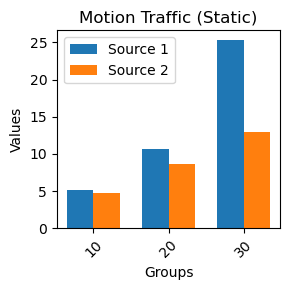

In [86]:
def plot_comparison_bar_graph(source1: np.ndarray, source2: np.ndarray, labels: list = None, title: str = 'Comparison of Two Sources', figsize=(10,6)) -> None:
    # Ensure the inputs are 2D arrays (N, 1)
    source1 = source1.reshape(-1, 1)
    source2 = source2.reshape(-1, 1)

    # Check if both arrays have the same length
    if source1.shape[0] != source2.shape[0]:
        raise ValueError("Both sources must have the same number of groups (N).")

    # Setting the number of groups (N)
    N = source1.shape[0]

    # Creating index for groups
    indices = np.arange(N)

    # Setting bar width
    bar_width = 0.35

    # Plotting bars
    plt.figure(figsize=figsize)
    plt.bar(indices - bar_width/2, source1.flatten(), width=bar_width, label='Source 1')
    plt.bar(indices + bar_width/2, source2.flatten(), width=bar_width, label='Source 2')

    # Adding labels
    if labels is not None and len(labels) == N:
        plt.xticks(indices, labels, rotation=45)
    else:
        plt.xticks(indices)

    plt.title(title)
    plt.xlabel('Groups')
    plt.ylabel('Values')
    plt.legend()
    plt.tight_layout()

    # Displaying the plot
    plt.show()

figsize = (3,3)
plot_comparison_bar_graph(perpCF_results[0], perpCA_results[0], ["10", "20", "30"], 'Motion Traffic (Static)', figsize)
#plot_comparison_bar_graph(perpCF_results[1], perpCA_results[1], ["10", "20", "30"], 'Haptic Traffic (Static)', figsize)